In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

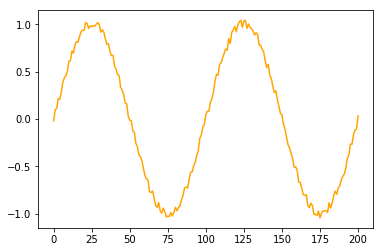

In [3]:
T = 100
f = toy_problem(T)
plt.plot(f, color='orange')
plt.show()

In [4]:
length_of_sequences = 2 * T  # 全時系列の長さ
maxlen = 25  # １つの時系列の長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [5]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [6]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

# TensorFlowによる実装

In [7]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    state = initial_state
    outputs = []  # 過去の隠れ層の出力を保存
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c  # 線形活性
    return y

In [8]:
def loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step

In [9]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [10]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

In [11]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [12]:
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

In [13]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size
early_stopping = EarlyStopping(patience=10, verbose=1)


for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                n_batch: batch_size
                })
            
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                n_batch: N_validation
            })   
            
            # 値を記録しておく
            print('epoch: ', epoch,
                 ' validation loss: ', val_loss)
            
            if early_stopping.validate(val_loss):
                break

epoch:  0  validation loss:  0.411382
epoch:  0  validation loss:  0.409213
epoch:  0  validation loss:  0.406989
epoch:  0  validation loss:  0.40476
epoch:  0  validation loss:  0.402483
epoch:  0  validation loss:  0.400148
epoch:  0  validation loss:  0.397792
epoch:  0  validation loss:  0.395408
epoch:  0  validation loss:  0.392961
epoch:  0  validation loss:  0.390449
epoch:  0  validation loss:  0.387941
epoch:  0  validation loss:  0.385367
epoch:  0  validation loss:  0.382649
epoch:  0  validation loss:  0.379868
epoch:  0  validation loss:  0.376938
epoch:  1  validation loss:  0.373878
epoch:  1  validation loss:  0.370654
epoch:  1  validation loss:  0.367284
epoch:  1  validation loss:  0.363724
epoch:  1  validation loss:  0.35997
epoch:  1  validation loss:  0.356046
epoch:  1  validation loss:  0.35191
epoch:  1  validation loss:  0.34777
epoch:  1  validation loss:  0.343406
epoch:  1  validation loss:  0.338895
epoch:  1  validation loss:  0.334101
epoch:  1  valid

epoch:  15  validation loss:  0.0054847
epoch:  16  validation loss:  0.00564902
epoch:  16  validation loss:  0.00563833
epoch:  16  validation loss:  0.00543587
epoch:  16  validation loss:  0.00522703
epoch:  16  validation loss:  0.00495502
epoch:  16  validation loss:  0.00472532
epoch:  16  validation loss:  0.00456003
epoch:  16  validation loss:  0.00439475
epoch:  16  validation loss:  0.00429134
epoch:  16  validation loss:  0.00430741
epoch:  16  validation loss:  0.00439425
epoch:  16  validation loss:  0.00442365
epoch:  16  validation loss:  0.00439974
epoch:  16  validation loss:  0.00431667
epoch:  16  validation loss:  0.00416734
epoch:  17  validation loss:  0.00406901
epoch:  17  validation loss:  0.00396282
epoch:  17  validation loss:  0.00387627
epoch:  17  validation loss:  0.00381722
epoch:  17  validation loss:  0.00378166
epoch:  17  validation loss:  0.00371072
epoch:  17  validation loss:  0.00368256
epoch:  17  validation loss:  0.00360574
epoch:  17  valid

epoch:  60  validation loss:  0.00120669
early stopping
epoch:  61  validation loss:  0.00130854
early stopping
epoch:  62  validation loss:  0.00151414
early stopping
epoch:  63  validation loss:  0.00163088
early stopping
epoch:  64  validation loss:  0.00173295
early stopping
epoch:  65  validation loss:  0.00173256
early stopping
epoch:  66  validation loss:  0.00164722
early stopping
epoch:  67  validation loss:  0.00146938
early stopping
epoch:  68  validation loss:  0.00125958
early stopping
epoch:  69  validation loss:  0.00108855
early stopping
epoch:  70  validation loss:  0.000936987
epoch:  70  validation loss:  0.000871278
epoch:  70  validation loss:  0.000871496
epoch:  70  validation loss:  0.000892793
epoch:  70  validation loss:  0.000932783
epoch:  70  validation loss:  0.000931075
epoch:  70  validation loss:  0.000895708
epoch:  70  validation loss:  0.000870388
epoch:  70  validation loss:  0.000879487
epoch:  70  validation loss:  0.000926593
epoch:  70  validati

epoch:  227  validation loss:  0.00166048
early stopping
epoch:  228  validation loss:  0.00166571
early stopping
epoch:  229  validation loss:  0.00163616
early stopping
epoch:  230  validation loss:  0.00153114
early stopping
epoch:  231  validation loss:  0.00150789
early stopping
epoch:  232  validation loss:  0.0015093
early stopping
epoch:  233  validation loss:  0.00161997
early stopping
epoch:  234  validation loss:  0.00164886
early stopping
epoch:  235  validation loss:  0.00151933
early stopping
epoch:  236  validation loss:  0.00139256
early stopping
epoch:  237  validation loss:  0.00131687
early stopping
epoch:  238  validation loss:  0.00137095
early stopping
epoch:  239  validation loss:  0.00148153
early stopping
epoch:  240  validation loss:  0.0015494
early stopping
epoch:  241  validation loss:  0.00164607
early stopping
epoch:  242  validation loss:  0.00161115
early stopping
epoch:  243  validation loss:  0.00152892
early stopping
epoch:  244  validation loss:  0.

epoch:  405  validation loss:  0.000953109
early stopping
epoch:  406  validation loss:  0.0010486
early stopping
epoch:  407  validation loss:  0.00121519
early stopping
epoch:  408  validation loss:  0.00133985
early stopping
epoch:  409  validation loss:  0.00150157
early stopping
epoch:  410  validation loss:  0.00155613
early stopping
epoch:  411  validation loss:  0.00149585
early stopping
epoch:  412  validation loss:  0.00140756
early stopping
epoch:  413  validation loss:  0.00135225
early stopping
epoch:  414  validation loss:  0.00135677
early stopping
epoch:  415  validation loss:  0.00130923
early stopping
epoch:  416  validation loss:  0.00121895
early stopping
epoch:  417  validation loss:  0.00113813
early stopping
epoch:  418  validation loss:  0.00108309
early stopping
epoch:  419  validation loss:  0.00103788
early stopping
epoch:  420  validation loss:  0.00100543
early stopping
epoch:  421  validation loss:  0.000995795
early stopping
epoch:  422  validation loss: 

In [14]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [15]:
for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
    (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

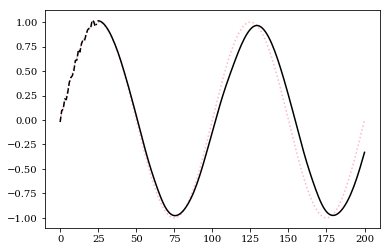

In [16]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Kerasによる実装

In [17]:
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [18]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

In [19]:
model = Sequential()
model.add(LSTM(n_hidden, init=weight_variable,
                   input_shape=(maxlen, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('linear'))

/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, input_shape=(25, 1), kernel_initializer=<function ...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer=<function ...)`
  after removing the cwd from sys.path.


In [20]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [22]:
epochs = 500
batch_size = 10

model.fit(X_train, Y_train, batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_validation, Y_validation),
         callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s 3ms/step - loss: 0.5154 - val_loss: 0.4034
Epoch 2/500
158/158 [==============================] - 0s 823us/step - loss: 0.4947 - val_loss: 0.3717
Epoch 3/500
158/158 [==============================] - 0s 843us/step - loss: 0.3950 - val_loss: 0.3074
Epoch 4/500
158/158 [==============================] - 0s 802us/step - loss: 0.3135 - val_loss: 0.2892
Epoch 5/500
158/158 [==============================] - 0s 1ms/step - loss: 0.2648 - val_loss: 0.2319
Epoch 6/500
158/158 [==============================] - 0s 882us/step - loss: 0.2225 - val_loss: 0.1965
Epoch 7/500
158/158 [==============================] - 0s 858us/step - loss: 0.1734 - val_loss: 0.1599
Epoch 8/500
158/158 [==============================] - 0s 832us/step - loss: 0.1338 - val_loss: 0.1228
Epoch 9/500
158/158 [==============================] - 0s 802us/step - loss: 0.0965 - val_loss: 0.0922
Epoch 10/500
158/158 [==========

In [23]:
truncate = 25
Z = X[:1]

original = [f[i] for i in range(25)]
predicted = [None for i in range(25)]

for i in range(200 - 25 + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
    (z_.reshape(25, n_in)[1:], y_),
    axis=0).reshape(1, 25, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

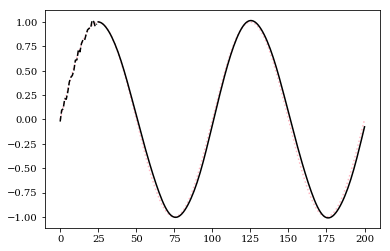

In [24]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Adding Problem

In [25]:
def mask(T=200):
    mask = np.zeros(T)
    indices = np.random.permutation(np.arange(T))[:2]
    mask[indices] = 1
    return mask

In [26]:
def toy_problem(N=10, T=200):
    signals = np.random.uniform(low=0.0, high=1.0, size=(N, T))
    masks = np.zeros((N, T))
    for i in range(N):
        masks[i] = mask(T)
        
    data = np.zeros((N, T, 2))
    data[:, :, 0] = signals[:]
    data[:, :, 1] = masks[:]
    target = (signals * masks).sum(axis=1).reshape(N, 1)
    
    return (data, target)

In [34]:
N = 10000
T = 200
maxlen = T

X, Y = toy_problem(N=N, T=T)

N_train = int(N * 0.9)
N_validation = N - N_train

n_in = len(X[0][0])  # 2
n_hidden = 100
n_out = len(Y[0])  # 1

In [ ]:
model = Sequential()
model.add(LSTM(n_hidden, init=weight_variable,
                   input_shape=(maxlen, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('linear'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='loss', patience=100, verbose=1)

epochs = 1000
batch_size = 100

hist = model.fit(X, Y, batch_size=batch_size,
         epochs=epochs,
         callbacks=[early_stopping])

/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, input_shape=(200, 2), kernel_initializer=<function ...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer=<function ...)`
  after removing the cwd from sys.path.


Epoch 1/1000
10000/10000 [==============================] - 19s 2ms/step - loss: 0.2921
Epoch 2/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1697
Epoch 3/1000
10000/10000 [==============================] - 19s 2ms/step - loss: 0.1696
Epoch 4/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1695
Epoch 5/1000
10000/10000 [==============================] - 19s 2ms/step - loss: 0.1694
Epoch 6/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1696
Epoch 7/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1698
Epoch 8/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1695
Epoch 9/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1698
Epoch 10/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1694
Epoch 11/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1690
Epoch 12/1000
10000/10000 [===

In [ ]:
loss = hist.history['loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(len(loss)), loss, label='loss', color='black')
plt.xlabel('epochs')
plt.show()